### Analysis of CROCOd0 simulation

The CROCOd1 simulation is the first child of the CROCOd0 simulation. This simulations was done with an offline nesting technique, and the simulation model the physical processes of the Humboldt current system on a 1/108° grid (~ 1km) around shore of the Coquimbo region and its surroundings (~30°S). The grid bathymetrhy was also created with GEBCO2022 dataset and includes 50 vertical levels of terrain following coordinates. For the grid creation it uses the same parameters of the CROCOd0 simulation, but the minimum depth is constrained to the minimum of 5m at the coast. 

The results, consists of daily model outputs of a 5 year interannual simulation that began in 2001 and ended in 2005. The atmospheric forcing consists again of daily averaged ERA5 fields and the lateral boundary conditions comes from roms2roms routine performed on the CROCOd0 outputs. The experiment, as part of the "ANID-SEQUIA" project, consist again of two simulations: the "crocod0_control" and the "crocod1_rivers", where the latter differs only by containing fictitious saline rivers that emulate the discharge of desalination plants.

The salinity of the desalination plant outfall was changed now to 75 PSU following the recomendations in *(Environmental issues in seawater reserse osmosis desalination: Intakes and outfalls. Missimer T, Maliva, R, 2018)*

The current jupyter notebook contains the postprocess and analysis of the control simulation and the main differences that comes with the saline rivers simulation. The results constits of an evaluation of salt accumulation on the long term and the expected spatial differences, the coastal changes of the seasonal cycle of salinity, the surface and depth differences in stratification, currents and salinity in the near field and the definition of an average area of influence for the desalination brine. 


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


In [2]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

In [4]:
# Load control simulation 
pathsavg_control = sorted(glob('data/DESALADORAS_RUND1/*avg*'))[:-1]
control_avg      = xr.open_mfdataset(pathsavg_control, parallel=True)
control_avg      = fix_crocotime(control_avg, YORIG='1949-12-30 23:59:50')
control_avg      = center_crocogrid(control_avg, control_avg.keys())

In [5]:
# Load virtual river simulation
pathsavg_rivers = sorted(glob('data/DESALADORAS_RUND1_RIOS/*avg*'))
rivers_avg      = xr.open_mfdataset(pathsavg_rivers, parallel=True)
rivers_avg      = fix_crocotime(rivers_avg, YORIG='1949-12-30 23:59:50')
rivers_avg      = center_crocogrid(rivers_avg, rivers_avg.keys())

In [6]:
# Grab sea level from each simulation
zeta_control = control_avg.zeta.load().where(gridd1.mask_rho==1)
zeta_rivers  = rivers_avg.zeta.load().where(gridd1.mask_rho==1)

In [7]:
# Load salinity fields in computer memory
salt_control = control_avg.salt.load()
salt_rivers  = rivers_avg.salt.load()

In [8]:
# Mask out land values
salt_control = salt_control.where(gridd1.mask_rho==1)
salt_rivers  = salt_rivers.where(gridd1.mask_rho==1)

In [9]:
# Grab closest pixel to coast sea level time series and total column depth
h_coast           = xr.concat([gridd1.h.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(len(gridd1.eta_rho))], 'eta_rho')
zetacontrol_coast = xr.concat([zeta_control.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(len(gridd1.eta_rho))], 'eta_rho')
zetarivers_coast  = xr.concat([zeta_rivers.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(len(gridd1.eta_rho))], 'eta_rho')

In [10]:
# Compute depth of sigma layers in the coastal pixels
zcontrol_coast = rhopoints_depths(h_coast.expand_dims(dim={'s_rho':control_avg.s_rho}), zetacontrol_coast, control_avg.s_rho, control_avg.Cs_r, control_avg.hc).load()
zrivers_coast  = rhopoints_depths(h_coast.expand_dims(dim={'s_rho':rivers_avg.s_rho}),  zetarivers_coast, rivers_avg.s_rho, rivers_avg.Cs_r, rivers_avg.hc).load()

zcontrol_coast.name = 'z_rho'
zrivers_coast.name  = 'z_rho'

In [12]:
# Get time series of the closest pixel to the coast
saltcontrol_coast = []
saltrivers_coast  = []
for e in range(len(gridd1.eta_rho)):
    if e%80==0:
        print('{:.2f}'.format(e/len(gridd1.eta_rho)))
    saltcontrol_coast.append(salt_control.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1))
    saltrivers_coast.append(salt_rivers.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1))
print('join')
saltcontrol_coast = xr.concat(saltcontrol_coast,'eta_rho')
saltrivers_coast = xr.concat(saltrivers_coast,'eta_rho')

0.00
0.14
0.28
0.42
0.57
0.71
0.85
0.99
join


In [16]:
# Interpolate coastal salinities from sigma coordinates to z coordinates
from xgcm import Grid
target_depths = np.arange(0,26+0.25,0.25)

husk = Grid(saltcontrol_coast.to_dataset(name='salt'), coords={'z':{'center':'s_rho'}}, periodic=False)
saltcontrol_coast = husk.transform(saltcontrol_coast,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)

husk = Grid(saltrivers_coast.to_dataset(name='salt'), coords={'z':{'center':'s_rho'}}, periodic=False)
saltrivers_coast  = husk.transform(saltrivers_coast,'z',-target_depths, target_data=zrivers_coast, method='linear', mask_edges=False)


In [382]:
# Mask out ficticious data outside the grid bathymetrhy
saltcontrol_coast = xr.concat([saltcontrol_coast.isel(eta_rho=n).where(-saltcontrol_coast.z_rho<h_coast.isel(eta_rho=n))
                          for n in range(len(saltcontrol_coast.eta_rho))], 'eta_rho')
saltrivers_coast  = xr.concat([saltrivers_coast.isel(eta_rho=n).where(-saltrivers_coast.z_rho<h_coast.isel(eta_rho=n))
                          for n in range(len(saltrivers_coast.eta_rho))], 'eta_rho')

Text(-31.9, 288.25, 'Los Vilos')

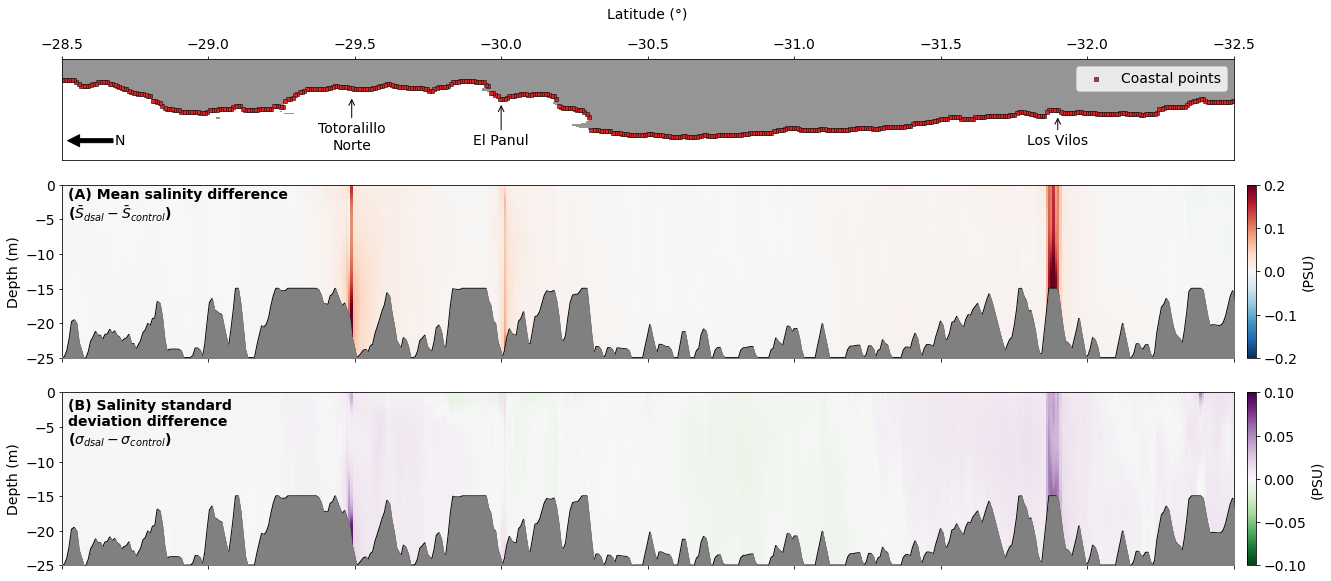

In [388]:
plt.rc('font', size=14)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(25,7))

for axis in ax:
    axis.fill_between(saltcontrol_coast.lat_rho,-h_coast.rolling({'eta_rho':3},center=True).mean().values,-27, zorder=3, color='grey')
    axis.plot(saltcontrol_coast.lat_rho, -h_coast.rolling({'eta_rho':3},center=True).mean().values, color='k')
    axis.set_ylabel('Depth (m)')

m=ax[0].pcolormesh(saltcontrol_coast.lat_rho, saltcontrol_coast.z_rho, (saltrivers_coast-saltcontrol_coast).mean('time').T.ffill('z_rho'), cmap='RdBu_r', norm=mcolors.Normalize(-0.2,0.2))
fig.colorbar(m, ax=ax[0], pad=0.01, label='(PSU)')

m=ax[1].pcolormesh(saltcontrol_coast.lat_rho, saltcontrol_coast.z_rho, (saltrivers_coast.std('time')-saltcontrol_coast.std('time')).T.ffill('z_rho'), cmap='PRGn_r', norm=mcolors.Normalize(-0.1,0.1))
fig.colorbar(m, ax=ax[1], pad=0.01, label='(PSU)')

ax[-1].set_ylim(-25,0)
ax[-1].set_xlim(-28.5,-32.5)
# ax[-1].set_xticks(np.arange(-32,-28.5,0.5));
ax[-1].set_xticklabels([])

ax[0].text(0.005,0.8,'(A) Mean salinity difference\n'+r'($\bar{S}_{dsal}-\bar{S}_{control}$)',ha='left', transform=ax[0].transAxes, weight='bold')
ax[1].text(0.005,0.7,'(B) Salinity standard\ndeviation difference\n($\sigma_{dsal}-\sigma_{control}$)',ha='left', transform=ax[1].transAxes, weight='bold')

box = ax[0].get_position()
ax2 = fig.add_axes([box.xmin,box.ymax+0.05,box.xmax-box.xmin,0.2])
ax2.pcolormesh(gridd1.lat_rho, gridd1.lon_rho, gridd1.mask_rho.where(gridd1.mask_rho==0), cmap='Greys', vmin=-1, vmax=1)
ax2.scatter(saltcontrol_coast.lat_rho,saltcontrol_coast.lon_rho, marker='s', color='tab:red', edgecolor='k', s=10, lw=0.5, label='Coastal points')
ax2.set_xlim(-28.5,-32.5)
ax2.set_ylim([288.1,288.9])
ax2.set_yticks([])

ax2.legend(loc='upper right')
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax2.set_xlabel('Latitude (°)\n')

ax2.annotate('N', xy=(-28.52, 288.25), xytext=(-28.7,288.25), ha='center', va='center',
             arrowprops=dict(facecolor='black', shrink=0.001))

ax2.annotate('Totoralillo\nNorte', xy=(-29.49, 360-71.4), xytext=(-29.49,288.28), ha='center', va='center',
             arrowprops=dict(facecolor='black', arrowstyle='->'))
ax2.annotate('El Panul', xy=(-30, 360-71.45), xytext=(-30,288.25), ha='center', va='center',
             arrowprops=dict(facecolor='black', arrowstyle='->'))
ax2.annotate('Los Vilos', xy=(-31.9, 360-71.55), xytext=(-31.9,288.25), ha='center', va='center',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

<function utils.croco_sellonlatbox(data, lonmin, lonmax, latmin, latmax)>

87 140
381 442
87 140
381 442


/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


82 134
317 378
82 134
317 378


/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


71 124
77 140
71 124
77 140


/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


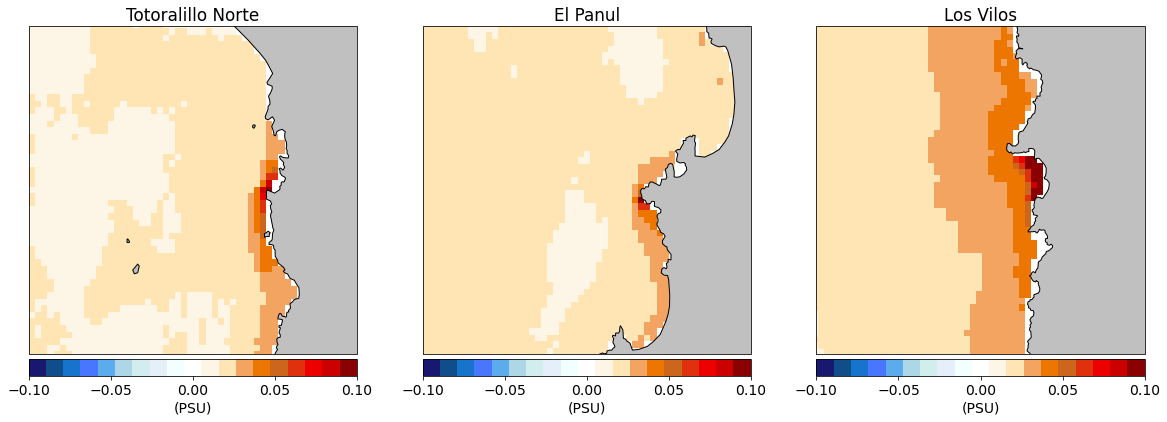

In [737]:
fig, ax = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(20,10))
points     = [(-29.49, 360-71.4),(-30, 360-71.45),(-31.9, 360-71.55)]
lonoffsets = -0.3,0.2
latoffsets = -0.2,0.2
titles = ['Totoralillo Norte', 'El Panul', 'Los Vilos']
for i, axis in enumerate(ax.ravel()):
    p = points[i]
    lonmin,lonmax=p[1]+lonoffsets[0],p[1]+lonoffsets[1]
    latmin,latmax=p[0]+latoffsets[0],p[0]+latoffsets[1]
    axis.set_extent([lonmin,lonmax,latmin,latmax])
    coastline.plot(ax=axis, edgecolor='k', color='silver',zorder=2)
    # croco_sellonlatbox(gridd1.where(gridd1.mask_rho==0),lonmin,lonmax,latmin,latmax).mask_rho.plot(ax=axis, add_colorbar=False)
    
    x = croco_sellonlatbox(salt_control,lonmin,lonmax,latmin,latmax+0.1).mean('s_rho')
    y = croco_sellonlatbox(salt_rivers,lonmin,lonmax,latmin,latmax+0.1).mean('s_rho')
    bias = (y-x).quantile(0.75,'time')
    bias.plot.pcolormesh(ax=axis, norm=mcolors.Normalize(-0.1,0.1), cmap=cmaps.hotcold_18lev,
                         x='lon_rho', y='lat_rho', cbar_kwargs={'orientation':'horizontal',
                                                                'pad':0.01,
                                                                'extend':'neither',
                                                                'label':'(PSU)'})
    axis.set_title(titles[i])
    

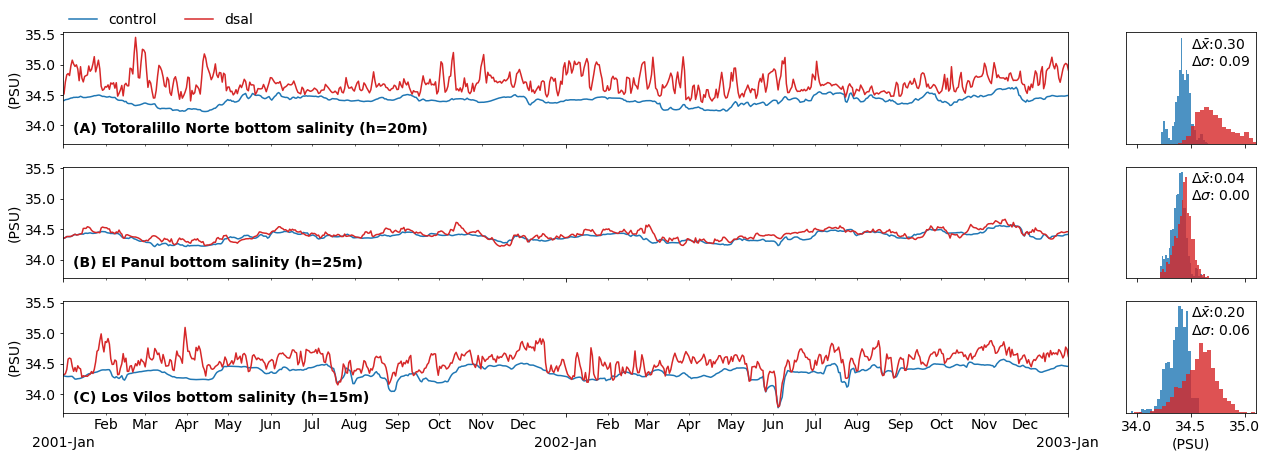

In [575]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(18,7))

paneltitle=['(A) Totoralillo Norte bottom salinity (h=20m)',
            '(B) El Panul bottom salinity (h=25m)',
            '(C) Los Vilos bottom salinity (h=15m)']
for i,e in enumerate(np.array([406,340,104])):
    ax[i].text(0.01,0.1,paneltitle[i],transform=ax[i].transAxes, ha='left', weight='bold')
    x = saltcontrol_coast.sel(eta_rho=e).dropna('z_rho').isel(z_rho=-1)
    y = saltrivers_coast.sel(eta_rho=e).dropna('z_rho').isel(z_rho=-1)

    ax[i].plot(x.time,x, label='control')
    ax[i].plot(y.time,y, color='tab:red',label='dsal')
    
    box = ax[i].get_position()
    newx = fig.add_axes([box.xmax*1.05,box.ymin,0.1,box.ymax-box.ymin])
    newx.hist(x, bins='auto', color='tab:blue', alpha=0.8, density=True)
    newx.hist(y, bins='auto', color='tab:red', alpha=0.8, density=True)
    newx.set_xlim(33.9,35.1)
    newx.set_xticks(np.arange(34,35+0.5,0.5))
    newx.set_yticks([])
    
    mdiff = (y-x).mean().item()
    sdiff = (y.std()-x.std()).item()
    newx.text(0.5,0.7,r'$\Delta\bar{x}$:'+'{:.2f}'.format(mdiff)+'\n$\Delta \sigma$: {:.2f}'.format(sdiff),
              transform=newx.transAxes, ha='left')
    ax[i].set_yticks(np.arange(34,36,0.5))
    if i!=2:
        newx.set_xticklabels([])
    else:
        newx.set_xlabel('(PSU)')
    
    
ax[0].legend(ncol=2, loc=(0,1), frameon=False)

for axis in ax.ravel():
    axis.set_ylabel('(PSU)')
    axis.set_xlabel('')
    axis.set_title('')
    axis.xaxis.set_minor_locator(mdates.MonthLocator(range(2,13)))
    axis.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    axis.xaxis.set_major_locator(mdates.YearLocator())
    axis.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y-%b'))
    axis.set_xlim(pd.to_datetime('2001'),pd.to_datetime('2003'))


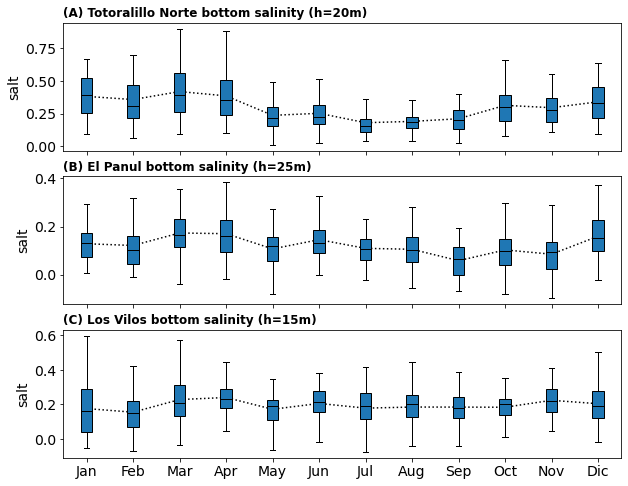

In [663]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False, figsize=(10,8))

paneltitle=['(A) Totoralillo Norte bottom salinity (h=20m)',
            '(B) El Panul bottom salinity (h=25m)',
            '(C) Los Vilos bottom salinity (h=15m)']
for i,e in enumerate([406,341,104]):
    ax[i].set_title(paneltitle[i], loc='left', weight='bold', fontsize=12)
    x = saltcontrol_coast.sel(eta_rho=e).dropna('z_rho').isel(z_rho=-1)
    x = saltrivers_coast.sel(eta_rho=e).dropna('z_rho').isel(z_rho=-1)-x
    
    for j,b in x.groupby('time.month'):
        ax[i].boxplot(b.values, positions=[j], sym='',
                      patch_artist=True, medianprops={'color':'k'},
                      widths=0.25, zorder=2)

    x.groupby('time.month').mean().plot(ax=ax[i], color='k', ls=':', zorder=0)
    ax[i].set_title('', loc='center')
    ax[i].set_xticks(np.arange(1,13))
    ax[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dic'])
    ax[i].set_xlabel('')
    # ax[i].set_ylim(-0.2,1)
